<a href="https://colab.research.google.com/github/yurimmmmmm/project/blob/main/Classification_without_prompt_final_20epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install using pip
!pip install transformers
!pip install gpytorch
!pip install torchmetrics
from torchmetrics.classification import MulticlassF1Score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.7 MB/s eta 0:00:00


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import transformers
import json
import os
from tqdm import tqdm
import torch.nn.functional as F
import gpytorch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
%matplotlib inline
logging.basicConfig(level=logging.ERROR)
from sklearn.metrics import classification_report

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
#############################################################
#Use below code to upload your kaggle.json to colab environment
#(you can download kaggle.json from your Profile->Account->API Token)
# 이 코드 실행하면, 밑에 파일 업로드하라고 되어 있을텐데,
# kaggle 가서  your Profile->Account->API Token에서 kaggle.json 다운 받아서 업로드 하면 됩니다
######################################################################3

from google.colab import files

files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d narayan63/netflix-popular-movies-dataset
!kaggle datasets download -d omkarborikar/top-10000-popular-movies

!unzip -q /content/netflix-popular-movies-dataset.zip
!unzip -q /content/top-10000-popular-movies.zip

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/1.17M [00:00<?, ?B/s]
100% 1.17M/1.17M [00:00<00:00, 156MB/s]
  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 176MB/s]


In [ ]:
train = pd.read_csv('/content/n_movies.csv', lineterminator='\n')
train1 = pd.read_csv('/content/Top_10000_Movies.csv', lineterminator='\n')

In [ ]:
#전처리
##############################################################
#위 두 데이터셋을 합치고, overview랑,genre, rating만 남겨놓게 전처리 한겁니다.
##############################################################3
duplicate = set(train['title'].values) & set(train1['original_title'].values)
for i in duplicate:
  train1 = train1[train1.original_title != i]
new_df = train[['rating', 'description', 'genre']]
new_df1 = train1[['vote_average', 'overview', 'genre']]
new_df1 = new_df1.rename(columns={"vote_average": "rating", "overview": "description"})
new_df = pd.concat([new_df, new_df1],ignore_index=True)
new_df = new_df[new_df.rating.notnull()]
new_df = new_df[new_df['rating']!= 0]
new_df = new_df[new_df.description != 'Add a Plot'] #description 란에 add a plot이란 text가 들어간 영화들이 있는데, 이 영화들은 빼준다
new_df = new_df[new_df.description != 'Nan']
new_df = new_df[new_df.description.notnull()]

In [ ]:
################################################
#prompt tuning으로 새로운 column 만들기
################################################
new_df['genre'] = 'this movie genre is' +' '+ new_df['genre']
new_df['description'] = 'this movie description is' +' '+ new_df['description']
new_df['new_input'] = new_df['description'] + ' ' + new_df['genre']

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 데이터 전처리를 마친 new_df 데이터프레임을 사용한다고 가정

# rating 데이터를 5개의 군으로 나누기
# 구간을 [0, 2), [2, 4), [4, 6), [6, 8), [8, 10]으로 나눔

bins = [0, 2, 4, 6, 8, 10]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
new_df['rating_group'] = pd.cut(new_df['rating'], bins=bins, labels=labels)

label_mapping = {'Very Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

new_df['rating_group_encoded'] = new_df['rating_group'].map(label_mapping)

new_df

,rating,description,genre,new_input,rating_group,rating_group_encoded
0,8.5,this movie description is Decades after their ...,"this movie genre is Action, Comedy, Drama",this movie description is Decades after their ...,Very High,4
1,8.7,this movie description is Follows the politica...,"this movie genre is Biography, Drama, History",this movie description is Follows the politica...,Very High,4
2,8.9,this movie description is The trials and tribu...,"this movie genre is Crime, Drama",this movie description is The trials and tribu...,Very High,4
3,5.9,this movie description is When a psychiatrist ...,"this movie genre is Drama, Horror, Mystery",this movie description is When a psychiatrist ...,Moderate,2
4,8.6,this movie description is A Street Kid trying ...,"this movie genre is Animation, Action, Adventure",this movie description is A Street Kid trying ...,Very High,4
...,...,...,...,...,...,...
18803,7.5,this movie description is Wallace and Gromit h...,"this movie genre is ['Adventure', 'Animation',...",this movie description is Wallace and Gromit h...,High,3
18804,7.0,this movie description is The rise and fall of...,"this movie genre is ['History', 'Drama', 'Music']",this movie description is The rise and fall of...,High,3
18805,6.6,this movie description is An American girl on ...,"this movie genre is ['Drama', 'Action', 'Thril...",this movie description is An American girl on ...,High,3
18806,7.4,this movie description is A vacuum repairman m...,"this movie genre is ['Drama', 'Music', 'Romance']",this movie description is A vacuum repairman m...,High,3


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(new_df, *['rating'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(new_df, *['rating'], **{})
chart

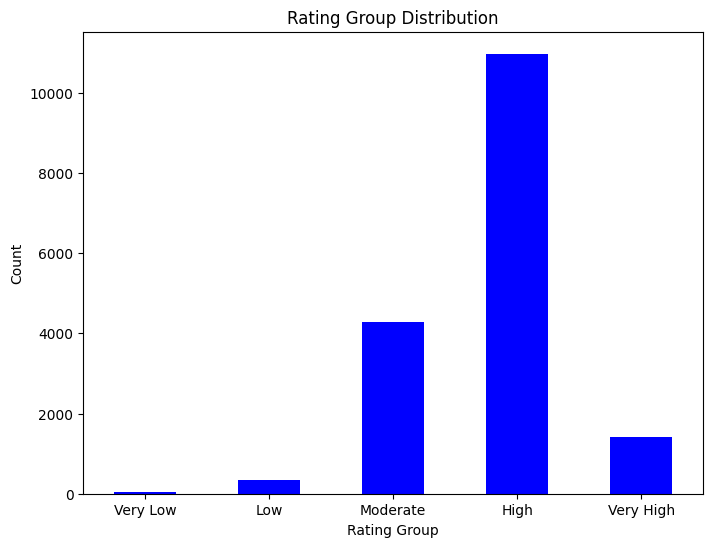

In [ ]:
import matplotlib.pyplot as plt

# rating 그룹별 빈도수 계산
rating_group_counts = new_df['rating_group_encoded'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(8, 6))
rating_group_counts.plot(kind='bar', color='blue')
plt.title('Rating Group Distribution')
plt.xlabel('Rating Group')
plt.ylabel('Count')
plt.xticks(rotation=0)  # x 축 레이블을 회전하지 않음
plt.xticks(range(5), labels)  # x 축 레이블을 rating 그룹의 레이블로 대체
plt.show()

In [ ]:
##########################################################
#model 학습 시 중간 중간 모델 weight를 저장해주는 function
##########################################################
from pathlib import Path

def save_ckpt(output_dir, model,likelihood, optimizer, epoch, filename):
    # save_ckpt: function for saving checkpoints
    output_dir = Path(output_dir)
    #saving ckpt for roberta
    if likelihood is None:
      if output_dir:
        checkpoint_path = output_dir / f'{filename}.pth'
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, checkpoint_path)
    #saving ckpt for gp regression
    else:
      if output_dir:
        checkpoint_path = output_dir / f'{filename}.pth'
        torch.save({
            'model': model.state_dict(),
            'likelihood': likelihood.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, checkpoint_path)


In [ ]:
# Defining some key variables that will be used later on in the training
# 학습 hyperparameter
MAX_LEN =512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class MovieData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.description  #### dataset에서 text input으로 쓰고 싶은 column명을 쓰면 됩니다
        self.targets = self.data.rating_group_encoded   #### dataset에서 우리의 target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MovieData(train_data, tokenizer, MAX_LEN)
testing_set = MovieData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (17065, 6)
TRAIN Dataset: (13652, 6)
TEST Dataset: (3413, 6)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class MLP(torch.nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = torch.nn.ModuleList(torch.nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.pre_classifier = MLP(768,768,768,3)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5) # regression이면 1, classification이면 5
        self._reset_parameters()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        ##### Roberta의 핵심 부분 freeze시킨다
        for param in self.l1.parameters():
          param.requires_grad = True


    def _reset_parameters(self):
        for p in self.parameters():
          if p.requires_grad == True and p.dim() > 1:
              torch.nn.init.xavier_uniform_(p)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state.detach().mean(dim=1)
        pooler = self.pre_classifier(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
# Defining the training function for classification
def train_classification(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    full_pred = []
    full_true_label = []
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        full_pred.append(big_idx.cpu().numpy())
        full_true_label.append(targets.cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        nb_tr_steps += 1
        # # When using GPU
        optimizer.step()
    #checkpoint 저장하기, 위에 save_ckpt 함수 참고하기
    target = [item for sublist in full_true_label for item in sublist]
    pred = [item for sublist in full_pred for item in sublist]
    print(classification_report(target, pred))
    ########save_ckpt 뒤에 filename을 저장하고 싶은 filename으로 바꿔주세요
    save_ckpt('/content/gdrive/MyDrive/ML_final', model, None, optimizer, epoch = epoch, filename='checkpoint_roberta_classification_without_prompt_20epochs_full_fine_tuning')
    print(f'The Total cross entropy loss for Epoch {epoch}: {tr_loss}')
    epoch_loss = tr_loss/nb_tr_steps
    print(f"Average Training Loss Epoch: {epoch_loss}")

    return

In [ ]:
####################################################################################
#*미리 모델을 학습한경우, 모델 학습 checkpoint 경로를 복사해서 resume에 넣어두면 됨.
#*처음부터 다시 시작하고 싶은 경우 resume = False로 해두기
####################################################################################
EPOCHS = 20
resume = False #'/content/gdrive/MyDrive/ML_final/checkpoint_roberta_classification_with_prompt_20epochs1.pth' #checkpoint pth file로의 경로를 넣어주시면 됩니다, 처음부터 학습하고 싶으면 resume = False
training = True # train 시키고 싶으면 True로 바꿔주세요
start_iter = 0
#creating model from robertaclass
model = RobertaClass()
model.to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss(weight = torch.tensor([437.5, 49.6,3.97,1.56,12.04]).to(device))
#for regression 밑에 줄을 쓰세요
#loss_function = torch.nn.MSE()
#classification metric f1 score
#metric = MulticlassF1Score(num_classes=5, average= 'macro')
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
if resume:
      checkpoint = torch.load(resume, map_location='cpu')
      model.load_state_dict(checkpoint['model'], strict = False)
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_iter = checkpoint['epoch']
if training:
  for epoch in range(start_iter, EPOCHS):
      train_classification(epoch)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.03      0.01      0.02       275
           2       0.26      0.34      0.29      3439
           3       0.65      0.52      0.57      8773
           4       0.09      0.15      0.11      1134

    accuracy                           0.43     13652
   macro avg       0.20      0.20      0.20     13652
weighted avg       0.49      0.43      0.45     13652

The Total cross entropy loss for Epoch 0: 1258.2333260774612
Average Training Loss Epoch: 1.473341131238245


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00       275
           2       0.27      0.38      0.32      3439
           3       0.65      0.51      0.57      8773
           4       0.11      0.18      0.14      1134

    accuracy                           0.44     13652
   macro avg       0.21      0.22      0.21     13652
weighted avg       0.50      0.44      0.46     13652

The Total cross entropy loss for Epoch 1: 1241.0893535614014
Average Training Loss Epoch: 1.4532662219688541


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00       275
           2       0.29      0.41      0.34      3439
           3       0.67      0.51      0.58      8773
           4       0.14      0.26      0.18      1134

    accuracy                           0.45     13652
   macro avg       0.22      0.23      0.22     13652
weighted avg       0.51      0.45      0.47     13652

The Total cross entropy loss for Epoch 2: 1223.5461806058884
Average Training Loss Epoch: 1.4327238648780893


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00       275
           2       0.31      0.43      0.36      3439
           3       0.67      0.47      0.55      8773
           4       0.14      0.34      0.20      1134

    accuracy                           0.44     13652
   macro avg       0.23      0.25      0.22     13652
weighted avg       0.52      0.44      0.46     13652

The Total cross entropy loss for Epoch 3: 1221.6154236793518
Average Training Loss Epoch: 1.4304630253856578


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.06      0.01      0.01       275
           2       0.33      0.50      0.40      3439
           3       0.68      0.43      0.53      8773
           4       0.15      0.38      0.22      1134

    accuracy                           0.44     13652
   macro avg       0.24      0.26      0.23     13652
weighted avg       0.53      0.44      0.46     13652

The Total cross entropy loss for Epoch 4: 1201.4219263195992
Average Training Loss Epoch: 1.4068172439339568


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.10      0.02      0.03       275
           2       0.33      0.51      0.40      3439
           3       0.69      0.43      0.53      8773
           4       0.17      0.42      0.24      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.28      0.24     13652
weighted avg       0.54      0.44      0.46     13652

The Total cross entropy loss for Epoch 5: 1193.263937175274
Average Training Loss Epoch: 1.3972645634370888


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.03      0.01      0.01       275
           2       0.35      0.54      0.42      3439
           3       0.70      0.40      0.51      8773
           4       0.17      0.47      0.25      1134

    accuracy                           0.43     13652
   macro avg       0.25      0.28      0.24     13652
weighted avg       0.55      0.43      0.46     13652

The Total cross entropy loss for Epoch 6: 1181.0055643320084
Average Training Loss Epoch: 1.382910496875888


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.05      0.01      0.01       275
           2       0.35      0.56      0.43      3439
           3       0.70      0.41      0.52      8773
           4       0.17      0.47      0.25      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.29      0.24     13652
weighted avg       0.56      0.44      0.46     13652

The Total cross entropy loss for Epoch 7: 1171.5057873129845
Average Training Loss Epoch: 1.371786636197874


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.08      0.01      0.02       275
           2       0.34      0.57      0.43      3439
           3       0.70      0.39      0.50      8773
           4       0.17      0.46      0.25      1134

    accuracy                           0.43     13652
   macro avg       0.26      0.29      0.24     13652
weighted avg       0.55      0.43      0.45     13652

The Total cross entropy loss for Epoch 8: 1168.7998544573784
Average Training Loss Epoch: 1.3686180965543073


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.04      0.02      0.02       275
           2       0.36      0.56      0.44      3439
           3       0.71      0.41      0.52      8773
           4       0.17      0.46      0.25      1134

    accuracy                           0.44     13652
   macro avg       0.25      0.29      0.25     13652
weighted avg       0.56      0.44      0.47     13652

The Total cross entropy loss for Epoch 9: 1166.9855952262878
Average Training Loss Epoch: 1.3664936712251614


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.08      0.03      0.05       275
           2       0.35      0.58      0.44      3439
           3       0.71      0.39      0.50      8773
           4       0.18      0.47      0.26      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.30      0.25     13652
weighted avg       0.56      0.44      0.46     13652

The Total cross entropy loss for Epoch 10: 1154.7198382616043
Average Training Loss Epoch: 1.3521309581517615


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.05      0.03      0.03       275
           2       0.36      0.58      0.45      3439
           3       0.71      0.40      0.51      8773
           4       0.18      0.49      0.26      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.30      0.25     13652
weighted avg       0.56      0.44      0.46     13652

The Total cross entropy loss for Epoch 11: 1148.0344169139862
Average Training Loss Epoch: 1.3443025959180166


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.07      0.07      0.07       275
           2       0.36      0.58      0.45      3439
           3       0.71      0.39      0.50      8773
           4       0.18      0.49      0.26      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.30      0.26     13652
weighted avg       0.56      0.44      0.46     13652

The Total cross entropy loss for Epoch 12: 1149.2512500882149
Average Training Loss Epoch: 1.3457274591196895


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.06      0.04      0.05       275
           2       0.36      0.58      0.45      3439
           3       0.72      0.38      0.50      8773
           4       0.18      0.52      0.27      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.30      0.25     13652
weighted avg       0.57      0.44      0.46     13652

The Total cross entropy loss for Epoch 13: 1143.8684228658676
Average Training Loss Epoch: 1.3394243827469177


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.07      0.08      0.07       275
           2       0.36      0.57      0.44      3439
           3       0.71      0.40      0.51      8773
           4       0.18      0.49      0.26      1134

    accuracy                           0.44     13652
   macro avg       0.27      0.31      0.26     13652
weighted avg       0.57      0.44      0.47     13652

The Total cross entropy loss for Epoch 14: 1135.9076449275017
Average Training Loss Epoch: 1.330102628720728


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.08      0.06      0.07       275
           2       0.37      0.56      0.44      3439
           3       0.71      0.41      0.52      8773
           4       0.18      0.51      0.27      1134

    accuracy                           0.45     13652
   macro avg       0.27      0.31      0.26     13652
weighted avg       0.57      0.45      0.47     13652

The Total cross entropy loss for Epoch 15: 1131.9565919041634
Average Training Loss Epoch: 1.3254761029322757


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.06      0.08      0.07       275
           2       0.36      0.57      0.44      3439
           3       0.72      0.39      0.50      8773
           4       0.18      0.50      0.27      1134

    accuracy                           0.44     13652
   macro avg       0.26      0.31      0.26     13652
weighted avg       0.57      0.44      0.46     13652

The Total cross entropy loss for Epoch 16: 1128.5267765522003
Average Training Loss Epoch: 1.3214599257051527


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.06      0.08      0.07       275
           2       0.37      0.56      0.44      3439
           3       0.72      0.40      0.51      8773
           4       0.18      0.51      0.26      1134

    accuracy                           0.44     13652
   macro avg       0.27      0.31      0.26     13652
weighted avg       0.57      0.44      0.47     13652

The Total cross entropy loss for Epoch 17: 1126.2866598963737
Average Training Loss Epoch: 1.318836838286152


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.06      0.11      0.08       275
           2       0.37      0.56      0.44      3439
           3       0.72      0.39      0.50      8773
           4       0.18      0.51      0.27      1134

    accuracy                           0.43     13652
   macro avg       0.27      0.31      0.26     13652
weighted avg       0.57      0.43      0.46     13652

The Total cross entropy loss for Epoch 18: 1124.5281559824944
Average Training Loss Epoch: 1.3167777002136936


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
854it [07:15,  1.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.07      0.12      0.09       275
           2       0.38      0.55      0.44      3439
           3       0.72      0.42      0.53      8773
           4       0.18      0.51      0.27      1134

    accuracy                           0.45     13652
   macro avg       0.27      0.32      0.27     13652
weighted avg       0.58      0.45      0.48     13652

The Total cross entropy loss for Epoch 19: 1119.3002797961235
Average Training Loss Epoch: 1.3106560653350392


In [ ]:
def valid_classification(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    true_targets = list()
    true_outputs = list()
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            true_targets.append(targets.cpu().numpy())
            outputs = model(ids, mask, token_type_ids).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            true_outputs.append(big_idx.cpu().numpy())
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            #big_val, big_idx = torch.max(outputs.data, dim=1)
            #n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            #if _%5000==0:
            #    loss_step = tr_loss/nb_tr_steps
            #    accu_step = (n_correct*100)/nb_tr_examples
            #    print(f"Validation Loss per 100 steps: {loss_step}")
            #    print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    #epoch_accu = (n_correct*100)/nb_tr_examples
    target = [item for sublist in true_targets for item in sublist]
    pred = [item for sublist in true_outputs for item in sublist]
    print(classification_report(target, pred))
    print(f"Validation Loss Epoch: {epoch_loss}")
    #print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, target, pred


In [ ]:
#############################
#validation classification
loss, true_target, true_output = valid_classification(model, testing_loader)
print("Average cross entropy loss on test data = %0.2f" % loss)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
214it [01:37,  2.20it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.06      0.05      0.05        66
           2       0.34      0.71      0.46       851
           3       0.73      0.30      0.42      2198
           4       0.19      0.46      0.27       287

    accuracy                           0.41      3413
   macro avg       0.26      0.30      0.24      3413
weighted avg       0.57      0.41      0.41      3413

Validation Loss Epoch: 1.374809446178864
Average cross entropy loss on test data = 1.37



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
